In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import json
import random
import time
import argparse
import pickle
#!{sys.executable} -m pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
import torch as T
import numpy as np
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, namedtuple
root = '/content/drive/My Drive/dialog-data/'
#root = 'drive/dialog-data/'
sys.path.append(root)
import slot_class_data3 as D
!{sys.executable} -m pip install transformers
import transformers as tf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 665kB 8.9MB/s 
     |████████████████████████████████| 890kB 23.2MB/s 
     |████████████████████████████████| 1.1MB 16.4MB/s 
     |████████████████████████████████| 3.8MB 50.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=681de8efcc7b9d9108ee77abc22d8f8595398e34e7dd41dff25dceafb4f0ae4d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
class Run:
    def __init__(self):
        self.records = defaultdict(list)
        
    def log(self, key, value):
        self.records[key].append(value)

def metrics(scores, labels):
    with T.no_grad():
        preds = T.max(scores, dim=-1)[1] == labels
        correct = T.where(preds == True)[0]
        wrong = T.where(preds == False)[0]
        return correct.shape[0]/scores.shape[0], correct.cpu().numpy(), wrong.cpu().numpy()

def evaluate(model, batch, test=False):
    scores = model(**batch.x._asdict())[0]
    loss = T.nn.functional.cross_entropy(scores, batch.y, reduction='none') # B
    
    with T.no_grad():
        preds = T.max(scores, dim=-1)[1] == batch.y
        i, corr, batch_size = 0, 0, 0
        mask = T.zeros_like(loss)
        while i < scores.shape[0]:
            j = batch.range[i].item()
            val = T.all(preds[i:j]).float().item()
            mask[i:j] = val
            corr += val
            i = j
            batch_size += 1
    loss = ((1 - mask) * loss).sum()/batch_size
    joint_acc = corr/batch_size
    if test:
        return loss, joint_acc, scores
    return loss, joint_acc
    
def print_example(tokenizer, batch, idx, scores, correct):
    id2label = sorted(D.SlotDataset.LABEL2ID.keys(), key=lambda x: D.SlotDataset.LABEL2ID[x])
    with T.no_grad():
        ids = batch.x.input_ids[idx]
        scores = T.softmax(scores[idx], dim=-1)
        state = ('Correct' if correct else 'Wrong')
        print(' '.join(tokenizer.convert_ids_to_tokens(ids, skip_special_tokens=True)))
        print('\t'.join([f'{id2label[i]}: {score:.2f}' for i, score in enumerate(scores)]+[state]))

def train(model, optim, train_data, valid_data, no_batches, valid_duration=100,
          cuda=True, verbose=False, tokenizer=None, max_grad_norm=1.0,
          valid_size=1, run=None, batch_size=1, no_examples=10):
    if cuda:
        model = model.cuda()
    optim, scheduler = optim
    print("About to start training")
    start_time = time.time()
    valid_loss, valid_acc, max_acc = 0, 0, 0
    print_gpu = False
    batch_size, total_batch_size = batch_size
    no_iter = total_batch_size//batch_size
    i = 0
    loss_fct = T.nn.CrossEntropyLoss(weight=T.tensor([1., 5.97, 181., 1]).cuda())
    while True:
        optim.zero_grad()
        scores, loss, acc = 0, 0, 0
        for k in range(no_iter):
            batch = next(train_data)
            #loss_, scores_= model(**batch.x._asdict(), labels=batch.y)[:2]
            #scores_ = model(**batch.x._asdict())[0]
            #loss_ = loss_fct(scores_.view(-1, 4), batch.y.view(-1))
            loss_, acc_ = evaluate(model, batch)
            #scores_ = scores_.detach()
            #scores += scores_/no_iter
            loss_ /= no_iter
            loss_.backward()
            loss += loss_.item()
            #acc_, _, _ = metrics(scores_ , batch.y)
            acc += acc_/no_iter
        if max_grad_norm > 0:
            T.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optim.step()
        scheduler.step()
        
        if  i % valid_duration == 0:
            model.eval()
            valid_acc, valid_loss = 0, 0
            with T.no_grad():
                if verbose:
                    print("##################################################################################")
                for k in range(valid_size):
                    batch = next(valid_data)
                    #valid_los, valid_scores = model(**batch.x._asdict(), labels=batch.y)[:2]
                    valid_los, v_acc, valid_scores = evaluate(model, batch, test=True)
                    _,  corr_ids, wrong_ids, = metrics(valid_scores, batch.y)
                    valid_loss += float(valid_los)
                    valid_acc += v_acc
                    if verbose and k < no_examples:
                        if len(corr_ids) > 0:
                            idx = np.random.choice(corr_ids)
                            print_example(tokenizer, batch, idx, valid_scores, correct=True)
                            print("-----------------------------------------------------------------------------")
                        if len(wrong_ids) > 0:
                            idx = np.random.choice(wrong_ids)
                            print_example(tokenizer, batch, idx, valid_scores, correct=False)
                            print("-----------------------------------------------------------------------------")
                if verbose:
                    print("##################################################################################")
                valid_loss /= valid_size
                valid_acc /= valid_size
                if valid_acc > max_acc:
                    max_acc = valid_acc
                    model.save_model()        
            model.train()
        
        if print_gpu:
            print(nvgpu.gpu_info())
            print_gpu = False
        if run:
            run.log("train_loss", loss)
            run.log("train_acc", acc)
            run.log("valid_loss", valid_loss)
            run.log("valid_acc", valid_acc)
            run.log("batch", i)
        sys.stderr.write(f'\rtrain loss: {loss:.2f}\ttrain acc {acc:.2f}\t' + 
                         f'valid loss: {valid_loss:.2f}\tvalid acc {valid_acc:.2f}' +
                         f'\tbatch: {i}\ttime: {time.time()-start_time:.2f}{"": <30}')
        i += 1
        if i >= no_batches - 1:
            break
    return model

def _in(n, trainable_parameters):
    return any(nd in n for nd in trainable_parameters)

def get_model(name, trainable_parameters=None):
    model_name = name.split('-')[0].capitalize()
    tokenizer = getattr(tf, f'{model_name}Tokenizer').from_pretrained(name)
    model = getattr(tf, f'{model_name}ForSequenceClassification').from_pretrained(name,
                                                                                  num_labels=4)
    if trainable_parameters is not None:
        for name, param in model.named_parameters():
            if not _in(name, trainable_parameters):
                param.requires_grad = False
    return tokenizer, model


class AdapterLayer(T.nn.Module):
    
    def __init__(self, input_size, dropout, hidden_size=64, init_scale=1e-3, act='gelu'):
        super().__init__()
        self.act = getattr(T.nn.functional, act)
        self.squeeze = T.nn.Linear(input_size, hidden_size)
        self.squeeze.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.squeeze.bias.data)
        self.expand = T.nn.Linear(hidden_size, input_size)
        self.expand.weight.data.normal_(mean=0.0, std=init_scale)
        T.nn.init.zeros_(self.expand.bias.data)
        self.dropout = dropout
        
    def forward(self, x):
        x = self.dropout(x)
        return self.expand(self.act(self.squeeze(x))) + x
    

def add_adapter_layers(model, **kwargs):
    input_size = model.config.hidden_size
    layers = model.bert.encoder.layer
    for layer in layers:
        adapter1 = AdapterLayer(input_size, layer.attention.output.dropout, **kwargs)
        adapter2 = AdapterLayer(input_size, layer.output.dropout, **kwargs)
        layer.attention.output.add_module('dropout', adapter1)
        layer.output.add_module('dropout', adapter2)
    return model


def save_model(model, trainable_parameters, url):
    with open(url, 'wb') as f:
        params_to_save = {k: v.detach().cpu() for k, v in model.state_dict().items()
                          if _in(k, trainable_parameters)}
        pickle.dump(params_to_save, f)


def load_model(model, url):
    with open(url, 'rb') as f:
        return model.load_state_dict(pickle.load(f), False)


def main(args):
    
    data_dir = args.data_url
    trainable_parameters = (args.trainable_parameters.split(' ') if args.trainable_parameters != '' 
                                                                 else None)
    print("data directory is: " + data_dir)
    # Load the model
    tokenizer, model = get_model(args.model_name, trainable_parameters)
    # Load the data
    train_itr = D.SlotDataset(os.path.join(data_dir,'train'), tokenizer, pos_prob=args.pos_prob, 
                              max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                               shuffle=True,
                                                               pin_memory=True, cuda=True,
                                                               loop=True, drop_last=True)
    valid_itr = D.SlotDataset(os.path.join(data_dir,'dev'), tokenizer, pos_prob=args.pos_prob, 
                              max_len=args.max_len).dataLoader(batch_size=args.batch_size,
                                                               shuffle=True,
                                                               pin_memory=True, cuda=True, 
                                                               loop=True, drop_last=True)
    # Train only adapter layers
    model = add_adapter_layers(model, hidden_size=args.adapter_size)
    if args.checkpoint:
        model.load_state_dict(pickle.load(open(os.path.join(data_dir, args.checkpoint), 'rb')),
                              False)
    # Parallise if required
    if T.cuda.device_count() > 1:
        print("Let's use", T.cuda.device_count(), "GPUs!")
        model = T.nn.DataParallel(model)    
    # Create the optimizer
    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() 
                       if _in(n, trainable_parameters) and not _in(n, no_decay)],
            "weight_decay": args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() 
                       if _in(n, trainable_parameters) and _in(n, no_decay)],
            "weight_decay": 0.0
        },
    ]
    if args.model_url is not None:
        save_fn = lambda : save_model(model, trainable_parameters, 
                                      os.path.join(data_dir, args.model_url))
    else:
        save_fn = type(None)
    setattr(model, 'save_model', save_fn)
    optimizer = tf.AdamW(optimizer_grouped_parameters, lr=args.lr, eps=1e-8)
    scheduler = tf.get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(0.1*args.num_batches), num_training_steps=args.num_batches
    )
    
    
    optim = [optimizer, scheduler]
    run = Run()
    model = train(model, optim, train_itr, valid_itr, args.num_batches, args.valid_duration,
                  cuda=True, verbose=args.verbose, tokenizer=tokenizer,
                  max_grad_norm=args.max_grad_norm, valid_size=args.valid_size,
                  run=run, batch_size=[args.batch_size, args.total_batch_size])
    return model, run

In [ ]:
trainable_parameters = ['LayerNorm', 'dropout.expand', 'dropout.squeeze', 'classifier']
# get command-line arguments
parser = argparse.ArgumentParser()
parser.add_argument('--model_name', type=str, default='bert-base-uncased')
parser.add_argument('--trainable_parameters', type=str, help='space separated parameters to train',
                    default=' '.join(trainable_parameters))
parser.add_argument('--total_batch_size', type=int, default=64, help='The total batch size')
parser.add_argument('--batch_size', type=int, default=64, help='The batch size')
parser.add_argument('--num_batches', type=int, default=1000, help='number of batches to train')
parser.add_argument('--max_len', type=int, default=120, help='Maximum length of the context')
parser.add_argument('--adapter_size', type=int, default=256, help='hidden size of the adapter layers')
parser.add_argument('--data_url', type=str, help='data directory')
parser.add_argument('--pos_prob', type=float, default=0.5, help='Probability of sampling positive examples')
parser.add_argument('--optim', type=str, default='Adam', help='data directory')
parser.add_argument('--lr', type=float, default=6e-5, help='Learning rate')
parser.add_argument('--amsgrad', type=bool, default=False, help=' whether to use the AMSGrad variant')
parser.add_argument('--weight_decay', type=float, default=0.006, help='L2 Regularization weight decay')
parser.add_argument('--max_grad_norm', default=1.0, type=float, help="Max gradient norm.")
parser.add_argument('--valid_duration', type=int, default=100, help='The number of batches before validating')
parser.add_argument('--verbose', type=bool, default=True, help='Show Live valid examples with prediction during validating')
parser.add_argument('--valid_size', type=int, default=50, help='The number of valid batches to evaluate')
parser.add_argument('--model_url', type=str, default='model.pkl', help='URL to save the model')
parser.add_argument('--checkpoint', type=str, help='Start training from a checkpoint')

args = parser.parse_args(['--data_url', root, '--model_url', 'model-slot-class3.pkl',
                          '--num_batches', '10000', '--adapter_size', '256', '--checkpoint', 'model-slot-class.pkl',
                          '--lr', '4e-5', '--batch_size', '6', '--total_batch_size', '60',
                          '--pos_prob', '0.5'])
model, run = main(args)

data directory is: /content/drive/My Drive/dialog-data/
About to start training
##################################################################################
system : the ticket is confirmed . user : please look for hotels in that area too . service description : accommodation searching and booking portal slot description : number of rooms to reserve
filled: 0.00	transferred: 0.00	dontcare: 0.00	None: 1.00	Correct
-----------------------------------------------------------------------------
system : please confirm transfer of $ 1 , 03 ##0 from your savings to the checking of justin . user : that ' s right . how many days will it take ? service description : service to manage your bank accounts and finances slot description : number of days for the transfer to go through
filled: 1.00	transferred: 0.00	dontcare: 0.00	None: 0.00	Wrong
-----------------------------------------------------------------------------
system : 7 : 10 am 10 buses $ 45 0 transfers user : that is good service 

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)
train loss: 0.07	train acc 0.93	valid loss: 0.35	valid acc 0.88	batch: 99	time: 449.01                              

##################################################################################
system : what event are you interested in ? and what city are you looking in ? user : it ' s the mariners vs rays . it should be in seattle . service description : the comprehensive portal to find and reserve seats at events near you slot description : sub ##cate ##gor ##y of event , either a music genre or sport name
filled: 0.00	transferred: 0.00	dontcare: 0.00	None: 1.00	Correct
-----------------------------------------------------------------------------
system : in which location are you searching for and what kind of food are you looking for ? user : find some good restaurants in sunny ##vale ? find hal ##al kind of food ? service description : a popular restaurant search and reservation service slot description : whether the restaurant has adequate vegetarian options
filled: 0.73	transferred: 0.00	dontcare: 0.00	None: 0.27	Wrong
---------------------------------------------------------------------

train loss: 0.20	train acc 0.85	valid loss: 0.35	valid acc 0.85	batch: 199	time: 898.63                              

##################################################################################
system : there ' s 10 events meeting your criteria out of which i recommend arizona vs la dodgers at chase field on march 1st at 6 pm . user : sounds nice , but please find me something on the 12th . service description : the comprehensive portal to find and reserve seats at events near you slot description : name of event
filled: 0.26	transferred: 0.00	dontcare: 0.00	None: 0.74	Correct
-----------------------------------------------------------------------------
system : there is $ 16 , 950 . 67 in your savings account . user : what about the balance of my checking account ? service description : service to manage your bank accounts and finances slot description : the balance in the specified account
filled: 0.08	transferred: 0.00	dontcare: 0.00	None: 0.91	Correct
-----------------------------------------------------------------------------
system : the room is $ 240 per night . user : that sounds good 

train loss: 0.15	train acc 0.93	valid loss: 0.33	valid acc 0.87	batch: 299	time: 1348.80                              

##################################################################################
system : where will you leave from ? user : nairobi is the departure city . service description : find one way and round trip flights to your favorite city slot description : number of bags to check in
filled: 0.00	transferred: 0.00	dontcare: 0.00	None: 1.00	Correct
-----------------------------------------------------------------------------
system : where will you leave from ? user : nairobi is the departure city . service description : find one way and round trip flights to your favorite city slot description : city in which the journey ends
filled: 0.72	transferred: 0.00	dontcare: 0.00	None: 0.28	Wrong
-----------------------------------------------------------------------------
system : what kind of restaurant ? user : i ' m in the mood for italian food . service description : a popular restaurant search and reservation service slot description : number of seats to reserve at the restaurant
filled: 

train loss: 0.14	train acc 0.92	valid loss: 0.32	valid acc 0.88	batch: 399	time: 1792.90                              

##################################################################################
system : there is 10 songs . do you like dance mac ##ab ##re by ghost from the album prequel ##le ? user : yes , i like that song . service description : a popular provider of a wide range of music content for searching and listening slot description : year in which the song was released
filled: 0.00	transferred: 0.00	dontcare: 0.00	None: 1.00	Correct
-----------------------------------------------------------------------------
system : hello , how can i help ? user : can you help me find a hotel in at ##l ? service description : accommodation searching and booking portal slot description : number of rooms to reserve
filled: 0.00	transferred: 0.00	dontcare: 0.00	None: 0.99	Correct
-----------------------------------------------------------------------------
system : their phone number is 70 ##7 - 44 ##8 - 38 ##48 . user : that ' s great . i don ' t need anything else . service description : a widely used

train loss: 0.17	train acc 0.88	valid loss: 0.33	valid acc 0.88	batch: 499	time: 2241.92                              

##################################################################################
system : do you need more help ? user : find me a one way flight there . service description : find one way and round trip flights to your favorite city slot description : number of the airport flying to mentioned in to location sf ##o
filled: 0.00	transferred: 0.00	dontcare: 0.00	None: 1.00	Correct
-----------------------------------------------------------------------------
system : it costs $ 261 per nights . the address is ci ##ra centre south , 292 ##9 walnut street . user : what else is there ? i need 1 room . service description : a popular service for searching and res ##erving rooms in hotels slot description : name of the hotel mentioned in offer hotel name aka university city
filled: 0.00	transferred: 0.01	dontcare: 0.00	None: 0.99	Correct
-----------------------------------------------------------------------------
system : the atrium inn vancouver is rated 3 stars . does this work for you ? 

train loss: 0.08	train acc 0.97	valid loss: 0.35	valid acc 0.89	batch: 599	time: 2692.08                              

##################################################################################
system : the average temperature will be 86 degrees fa ##hre ##nh ##eit with a 21 percent chance of rain user : ok , what about the weather in las vegas service description : check the weather for any place and any date slot description : the possibility of rain or snow in percentage
filled: 0.00	transferred: 0.00	dontcare: 0.00	None: 1.00	Correct
-----------------------------------------------------------------------------
system : you can reach them at 70 ##7 - 226 - 99 ##12 and visit them at 57 ##5 lincoln avenue # 305 ##c user : can you book me an apartment on the 13th of march ? service description : discover the right therapist for you and make reservations easily slot description : contact number of the therapist
filled: 0.00	transferred: 0.00	dontcare: 0.00	None: 1.00	Correct
-----------------------------------------------------------------------------
system : hello , how can i help ? user : i a

train loss: 0.28	train acc 0.88	valid loss: 0.38	valid acc 0.90	batch: 661	time: 2976.62                              

In [ ]:
!nvidia-smi

Tue Jun  2 01:55:21 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
save_model(model, trainable_parameters, root + 'model-slot-class-joint-best.pkl')

/home/osman/anaconda3/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [ ]:
import transformers as tf
import slot_class_data2 as D
tokenizer = tf.BertTokenizer.from_pretrained('bert-base-uncased')
dataset = D.SlotDataset(root + 'test', tokenizer, max_len=120)

In [ ]:
batches = dataset.load_valid_data(128)

In [ ]:
model = tf.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model = add_adapter_layers(model, hidden_size=256)
load_model(model, root + 'model-slot-class3.pkl')

_IncompatibleKeys(missing_keys=['bert.embeddings.word_embeddings.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.output.dense.weight', 'bert.encoder.layer.0.output.dense.bias', 'bert.encoder.layer.1.attention.self.query.weight', 'bert.encoder.layer.1.attention.self.query.bias', 'bert.encoder.layer.1.attention.self.key.weight', 'bert.encoder.layer.1.attention.self.key.bias', 'bert.encoder.layer.1.attention.self.val

In [ ]:
def evaluate_valid_data(model, valid_data):
    model.eval()
    with T.no_grad():
        acc, count = 0, 0
        scores, slots, ids = [], [], []
        for i, batch in enumerate(valid_data):
            batch = D.SlotDataset.map_to_cuda(batch)
            scores_ = model(**batch.x._asdict(), labels=batch.y)[1]
            acc_, _, _ = metrics(scores_, batch.y)
            acc += (acc_*len(batch.y))
            count += len(batch.y)
            scores.append(scores_.cpu().numpy())
            slots += batch.slot
            ids += batch.id
            sys.stderr.write(f'\r{i}/{len(valid_data)} acc: {acc_}{"": <30}')
        acc = acc/count
        scores = np.concatenate(scores)
    model.train()
    return {'acc': acc, 'scores': scores.tolist(), 'labels': slots, 'ids': ids}

In [ ]:
results = evaluate_valid_data(model.cuda(), batches)

1429/1430 acc: 0.975                              

In [ ]:
print(results['acc']) # test set model-slot-class3

0.9509213517530821


In [ ]:
print(results['acc'])# test set model-slot-class2

0.9481780624289586


In [ ]:
print(results['acc'])# test set model-slot-class

0.9518667482731485


In [ ]:
print(results['acc'])#joint-acc from start 29-05

0.9749626274471189


In [ ]:
print(results['acc'])#joint-acc and better 0.9786596009416988 for 25-05

0.975813020865969


In [ ]:
print(results['acc'])#18-05

0.962323095790105


In [ ]:
print(results['acc'])#best 2

0.9106562888987452


In [ ]:
print(results['acc'])

0.9557323337100997


In [ ]:
print(results['acc'])

0.961441059905856


In [ ]:
print(results['acc'])

0.9614339061136309


In [ ]:
print(results['acc'])

0.9503240667878042


In [ ]:
print(results['acc'])

0.9465897872462192


In [ ]:
print(results['acc'])

0.9110497474711344


In [ ]:
print(results['acc'])

0.9256434836106621


In [ ]:
print(results['acc'])

0.9163149385489248


In [ ]:
print(results['acc'])

0.9445938792153721


In [ ]:
print(results['acc'])

0.9462645383125192


In [ ]:
print(results['acc'])

0.9107792606995546


In [ ]:
print(results['acc'])

0.925441418257202


In [ ]:
import json
with open(root + 'test-slot-scores-02-06.json', 'w') as f:
    json.dump(results, f)

In [ ]:
trainable_parameters = ['LayerNorm', 'dropout.expand', 'dropout.squeeze', 'classifier']
save_model(model, trainable_parameters, root + 'model-slot-class-24-05.pkl')

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [ ]:
CLASSES = ['filled', 'transferred', 'dontcare', 'None']
import numpy as np
def softmax(x):
    return np.exp(x)/sum(np.exp(x))
def get_per_class_acc(results):
    total = {k: 0 for k in CLASSES}
    correct = {k: 0 for k in CLASSES}
    for score, label in zip(results['scores'], results['labels']):
        correct_idx = int(label.split('--')[-1])
        #if correct_idx == 1:
        #    correct_idx = 0
        total[CLASSES[correct_idx]] += 1
        #score = softmax(score).tolist()
        #score = [score[0] + score[1]] + score[2:]
        pred_idx = int(np.argmax(score))# + 1
        #if pred_idx == 1:
        #    pred_idx = 0
        if pred_idx == correct_idx:
            correct[CLASSES[correct_idx]] += 1
    return {k: (v/(total[k]+1e-25), total[k]) for k, v in correct.items()}

In [ ]:
get_per_class_acc(results) # joint-acc 29-05

{'filled': (0.9579210345841089, 20414),
 'transferred': (0.9747545582047685, 3565),
 'dontcare': (0.67, 100),
 'None': (0.9792888604879385, 87634)}

In [ ]:
get_per_class_acc(results) # joint-acc 24-05

{'None': (0.9809206472373736, 87634),
 'dontcare': (0.63, 100),
 'filled': (0.964828059175076, 20414),
 'transferred': (0.9228611500701263, 3565)}

In [ ]:
get_per_class_acc(results) # 18-05

{'filled': (0.9715391398060155, 20414),
 'transferred': (0.9506311360448808, 3565),
 'dontcare': (0.71, 100),
 'None': (0.9609398178789055, 87634)}

In [ ]:
get_per_class_acc(results) # 18-05

{'filled': (0.9704741648942825, 23979),
 'transferred': (0.0, 0),
 'dontcare': (0.71, 100),
 'None': (0.9609398178789055, 87634)}

In [ ]:
get_per_class_acc(results) # 'model-slot-class-512-11-05-prev-states.pkl'

{'filled': (0.9044067466120698, 20514),
 'transferred': (0.862914862914863, 3465),
 'dontcare': (0.52, 100),
 'None': (0.9748848384280986, 115707)}

In [ ]:
get_per_class_acc(results)

{'filled': (0.910254806288836, 23979),
 'transferred': (0.0, 0),
 'dontcare': (0.52, 100),
 'None': (0.9748848384280986, 115707)}

In [ ]:
get_per_class_acc(results) # best4

{'None': (0.9644360323921629, 115707),
 'dontcare': (0.45, 100),
 'filled': (0.8900755913191905, 20505),
 'transferred': (0.8503166378814048, 3474)}

In [ ]:
get_per_class_acc(results) # best1

{'None': (0.9306869938724537, 115707),
 'dontcare': (0.76, 100),
 'filled': (0.9569206388923641, 23979),
 'transferred': (0.0, 0)}

In [ ]:
get_per_class_acc(results) # best2

{'None': (0.901198717450111, 115707),
 'dontcare': (0.79, 100),
 'filled': (0.9739772300763168, 23979),
 'transferred': (0.0, 0)}

In [ ]:
get_per_class_acc(results) # best2

{'None': (0.901198717450111, 115707),
 'dontcare': (0.79, 100),
 'filled': (0.9628940669669082, 20428),
 'transferred': (0.9372007885102788, 3551)}

In [ ]:
get_per_class_acc(results) # best3

{'None': (0.9529241964617525, 115707),
 'dontcare': (0.71, 100),
 'filled': (0.9306059468701781, 23979),
 'transferred': (0.0, 0)}

In [ ]:
get_per_class_acc(results)

{'None': (0.9529241964617525, 115707),
 'dontcare': (0.71, 100),
 'filled': (0.9205012727628745, 20428),
 'transferred': (0.8969304421289778, 3551)}

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

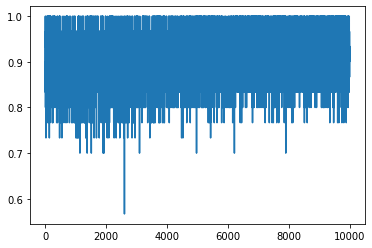

In [ ]:
plt.plot(run.records['train_acc'])

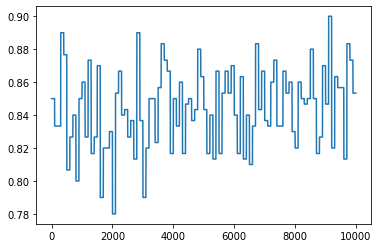

In [ ]:
plt.plot(run.records['valid_acc'])

In [ ]:
DataLoader()

In [ ]:
print_example(tokenizer, b, 0, output[1], False)

system : hello , how can i help ? user : i wish to search a movie to watch online . drama movie service description : the wide ##st selection and lowest prices for movie rental ##s slot description : name of an actor starring
filled: 0.22	transferred: 0.21	dontcare: 0.16	None: 0.40	Wrong


In [ ]:
b.y

tensor([0, 3, 0, 3, 0, 0, 3, 0, 3, 3])

In [ ]:
import slot_class_data as D

In [ ]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element